# Volatility Signal Experiment

This notebook explores whether refining ATR breakout signals using predicted high-volatility probabilities (`prob_high_vol`) improves trading performance.  

Research question: Can current realized volatility classify future volatility regimes (high vs low), and does this information have trading value?

Despite reasonable classification metrics, the strategy does not produce a consistent trading edge. The notebook is primarily for documenting the experiment.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [138]:
df = pd.read_csv("/Users/nathr/Downloads/spy_yahoo.csv")
numeric_cols = ["Open", "High", "Low", "Close", "Volume"] 
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.dropna(subset=numeric_cols)
df.head()

,Price,Open,High,Low,Close,Volume
2,2000-01-03,148.25000,148.25000,143.875000,145.4375,8164300.0
3,2000-01-04,143.53125,144.06250,139.640625,139.7500,8089800.0
4,2000-01-05,139.93750,141.53125,137.250000,140.0000,12177900.0
5,2000-01-06,139.62500,141.50000,137.750000,137.7500,6227200.0
6,2000-01-07,140.31250,145.75000,140.062500,145.7500,8066500.0


## Labels

Future volatility is defined as realized volatility over the next 5 trading days.  
Observations are classified as high or low volatility based on whether future realized volatility exceeds the sample median.


In [141]:
df["returns"] = np.log(df["Close"]).diff()
df["vol_20d"] = df["returns"].rolling(window=20).std()
df["future_vol_5d"] = (
    df["returns"]
    .rolling(5)
    .std()
    .shift(-5)
)

In [143]:
threshold = df["future_vol_5d"].median()
df["high_vol"] = (df["future_vol_5d"] > threshold).astype(int)
df = df.dropna(subset=["vol_20d", "high_vol"])

In [145]:
X = df[["vol_20d"]]
y = df["high_vol"]


In [147]:
split = int(len(data) * 0.7)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


## Model

A logistic regression model predicts the probability of a high-volatility regime using current realized volatility as the sole feature.  
The data is split chronologically to avoid look-ahead bias.


In [150]:
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

## Results

The model assigns higher probabilities to high-volatility regimes when current volatility is elevated.  
Out-of-sample ROC–AUC is approximately 0.76, indicating reasonable ranking performance.


In [153]:
model.coef_
model.intercept_


array([-0.06835253])

The intercept is close to zero in log-odds space, consistent with the approximately balanced regime definition.


In [156]:
proba = model.predict_proba(X_test)[:, 1]

In [158]:
#evaluation
auc = roc_auc_score(y_test, proba)
print("AUC:", auc)


AUC: 0.7600141868975082


Out-of-sample ROC–AUC is approximately 0.76, suggesting reasonable ranking ability between high- and low-volatility observations.

However, this metric reflects statistical separability rather than economic usefulness and does not imply the existence of a tradable edge.


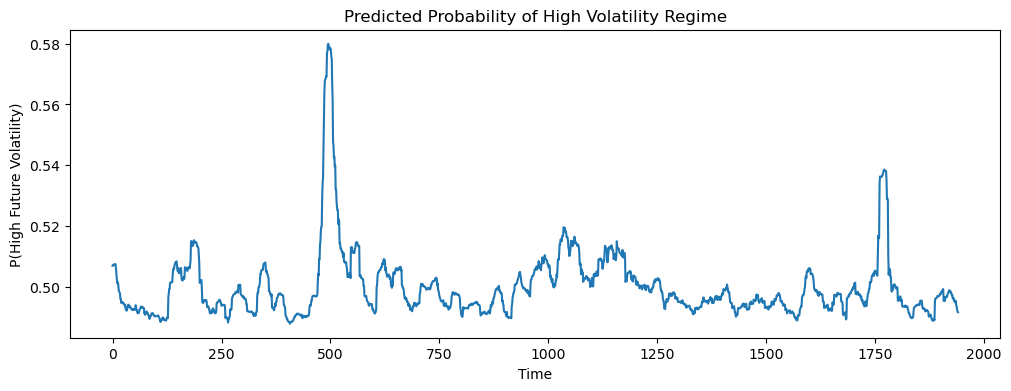

In [161]:
plt.figure(figsize=(12,4))
plt.plot(proba)
plt.xlabel("Time")
plt.ylabel("P(High Future Volatility)")
plt.title("Predicted Probability of High Volatility Regime")
plt.show()


The predicted probabilities closely track realized volatility, indicating that the model primarily learns volatility persistence rather than identifying distinct regime transitions.


### Conclusion
This experiment highlights the distinction between statistical predictability and trading relevance.

While future volatility can be ranked using current realized volatility, this information provides limited incremental value for decision-making once converted into discrete trading signals.


### Extension of Volatility Breakout Backtest

This notebook expands on the signal generation logic from [`Volatility Breakout Backtest.ipynb`].
We reuse the existing backtest code to evaluate whether refining the breakout signals using predicted high-volatility probabilities (`df["prob_high_vol"] = model.predict_proba(X)[:, 1]`) leads to improved trading performance.  
Results are examined below.


In [243]:
df["prob_high_vol"] = model.predict_proba(X)[:, 1]

In [245]:
def compute_atr(df, window=20):
    """
    Compute daily range and ATR (rolling mean of range)
    Returns a new DataFrame, no prints
    """
    df = df.copy()  # avoid SettingWithCopyWarning
    df["Range"] = df["High"] - df["Low"]
    df["ATR"] = df["Range"].rolling(window).mean()
    return df

In [224]:
def volatility_breakout_signal_lr(df, k=1.5, prob_col="prob_high_vol", threshold=0.5):
    """
    Generate signals based on ATR breakout, but only trade if
    logistic regression predicts high volatility.
    """
    df = df.copy()
    df["Signal"] = 0
    
    # ATR breakout
    breakout_mask = df["Range"] > k * df["ATR"]
    
    # Filter by probability
    filtered_mask = breakout_mask & (df[prob_col] > threshold)
    
    # Assign directional signal
    df.loc[filtered_mask, "Signal"] = (df["Close"] - df["Open"]).apply(np.sign)[filtered_mask]
    
    return df


In [226]:
def build_positions(df, holding_period=5):
    df = df.copy()
    df["Position"] = 0

    positions = df["Position"].values
    signals = df["Signal"].values

    for t in range(len(df)):
        if signals[t] != 0:
            start = t + 1
            end = min(t + 1 + holding_period, len(df))
            positions[start:end] += signals[t]

    df["Position"] = positions
    return df

In [228]:
def compute_strategy_returns(df, cost_per_trade=0.001):
    """
    Compute daily returns and net strategy returns including transaction costs.
    """
    df = df.copy()
    # Daily returns of the asset
    df["Return"] = df["Close"].pct_change()

    # Strategy return based on previous day’s position
    df["StrategyReturn"] = df["Position"].shift(1) * df["Return"]

    # Turnover = absolute change in position
    df["Turnover"] = df["Position"].diff().abs()

    # Costs
    df["Cost"] = df["Turnover"] * cost_per_trade

    # Net returns
    df["NetStrategyReturn"] = df["StrategyReturn"] - df["Cost"]

    return df

In [231]:
# Compute features
df = compute_atr(df, window=20)

# Generate signals
df = volatility_breakout_signal(df, k=1.5)

# Build positions
df = build_positions(df, holding_period=5)

# Compute returns including costs
df = compute_strategy_returns(df, cost_per_trade=0.001)

In [233]:
df[["NetStrategyReturn"]].describe()

,NetStrategyReturn
count,6515.000000
mean,-0.000048
std,0.009358
min,-0.291395
25%,0.000000
50%,0.000000
75%,0.000000
max,0.130533


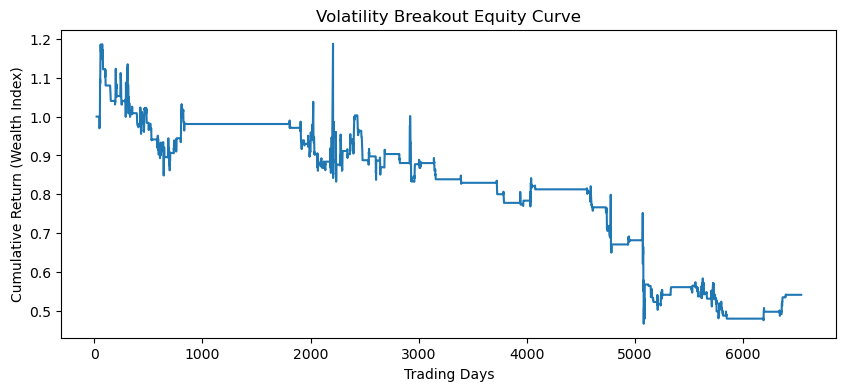

In [235]:
equity = (1 + df["NetStrategyReturn"].fillna(0)).cumprod()

plt.figure(figsize=(10, 4))
plt.plot(equity)
plt.title("Volatility Breakout Equity Curve")
plt.xlabel("Trading Days")
plt.ylabel("Cumulative Return (Wealth Index)")
plt.show()

### Trading Performance

The refined volatility breakout strategy produces an equity curve that is active in some periods and quiet in others, reflecting the selective nature of the signals.  

Despite this, the overall performance is negative: the mean strategy return is effectively zero and the strategy ends slightly loss-making, indicating that the refinement of the signals did not create a tradable edge.
